In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

data = pd.read_csv('../../data/nama-gender-titik.csv', sep=";")
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'f' else 0)
names = data[['name', 'gender']].values.tolist()

def name_to_sequence(name):
    char_to_int = dict((c, i) for i, c in enumerate('abcdefghijklmnopqrstuvwxyz '))
    sequence = [char_to_int[char.lower()] for char in name if char.lower() in char_to_int]
    return sequence

def name_to_vector(name):
    sequence = name_to_sequence(name)
    vector = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=29, padding='post')[0]
    return vector

In [2]:
x_train = np.array([name_to_vector(name[0]) for name in names])
y_train = np.array([name[1] for name in names])

In [3]:
# Defining the model architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(29,))),
model.add(tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=29)),
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')),
model.add(tf.keras.layers.MaxPooling1D(pool_size=2)),
model.add(tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')),
model.add(tf.keras.layers.MaxPooling1D(pool_size=2)),
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')),
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))),
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))),
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))),
model.add(tf.keras.layers.Dense(128, activation='relu')),
model.add(tf.keras.layers.Dropout(0.4)),
model.add(tf.keras.layers.Dense(64, activation='relu')),
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
hist = model.fit(x_train, y_train, validation_data=(x_train, y_train), epochs=10)

Epoch 1/10


2023-04-24 05:42:54.982444: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19508/19508 [==============================] - 1372s 70ms/step - loss: 0.1923 - accuracy: 0.9214 - val_loss: 0.1560 - val_accuracy: 0.9367
Epoch 2/10
19508/19508 [==============================] - 1311s 67ms/step - loss: 0.1532 - accuracy: 0.9389 - val_loss: 0.1416 - val_accuracy: 0.9435
Epoch 3/10
19508/19508 [==============================] - 1321s 68ms/step - loss: 0.1437 - accuracy: 0.9428 - val_loss: 0.1397 - val_accuracy: 0.9454
Epoch 4/10
19508/19508 [==============================] - 1352s 69ms/step - loss: 0.1376 - accuracy: 0.9454 - val_loss: 0.1290 - val_accuracy: 0.9491
Epoch 5/10
19508/19508 [==============================] - 1346s 69ms/step - loss: 0.1335 - accuracy: 0.9470 - val_loss: 0.1257 - val_accuracy: 0.9501
Epoch 6/10
19508/19508 [==============================] - 1344s 69ms/step - loss: 0.1304 - accuracy: 0.9481 - val_loss: 0.1232 - val_accuracy: 0.9511
Epoch 7/10
19508/19508 [==============================] - 1275s 65ms/step - loss: 0.1283 - accuracy: 0.9492 - v

In [12]:
model.save('../../models/gender-mixed-base.h5')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 64)            320000    
                                                                 
 conv1d (Conv1D)             (None, 29, 16)            3088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 64)             6

In [14]:
score = model.evaluate(x_train, y_train)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

19508/19508 [==============================] - 471s 24ms/step - loss: 0.1222 - accuracy: 0.9520

ACCURACY: 0.951997697353363
LOSS: 0.12219194322824478


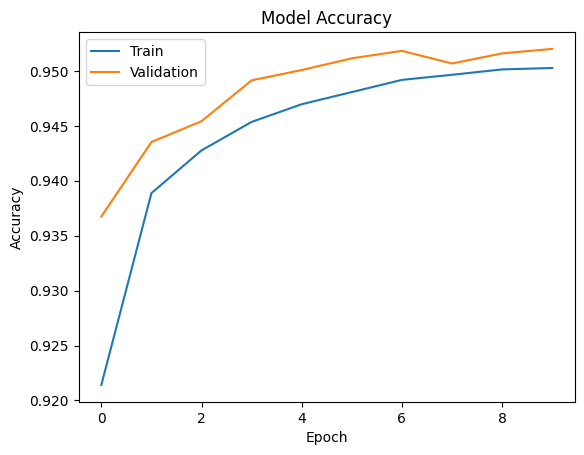

In [15]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

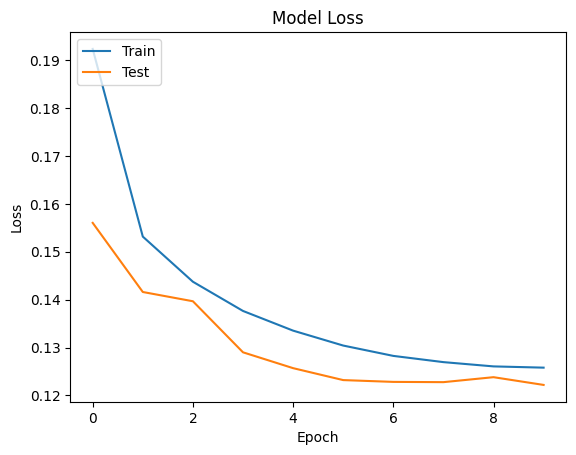

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

labels_pred = model.predict(x_train)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(y_train, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

19508/19508 [==============================] - 396s 20ms/step
Accuracy: 95.20%


In [18]:
print(classification_report(y_train, labels_pred, digits=5))

              precision    recall  f1-score   support

           0    0.95621   0.95063   0.95341    322538
           1    0.94755   0.95346   0.95049    301703

    accuracy                        0.95200    624241
   macro avg    0.95188   0.95204   0.95195    624241
weighted avg    0.95202   0.95200   0.95200    624241



In [19]:

def predict_gender(name):
    name_vector = np.array(name_to_vector(name))
    padded_name_vector = tf.keras.preprocessing.sequence.pad_sequences([name_vector], maxlen=29, padding='post', truncating='post')
    prediction = model.predict(padded_name_vector)
    
    if prediction < 0.5:
        return 'Male'
    else:
        return 'Female'

nama = [
  'Novi Gustiana', 
  'Novia Kumala Sari', 
  'Novianto Rahmadi', 
  'Padli Nofrizal', 
  'Putri Wahyuni', 
  'Rahmat Hidayat', 
  'Rahmi Andreni', 
  'Rian Aries Fani', 
  'Riandi Selvi', 
  'Rianto', 
  'Ridha Ulva', 
  'Rizqi Wahyuningsih', 
  'Ruwadi Saputra', 
  'Sugeng Hermawan', 
  'Suliatun', 
  'Tomi Ismeidianto', 
  'Usthalay Putra', 
  'Winggo Aga Septian', 
  'Yunaldi Rizki Putra', 
  'Arif fasetyo', 
  'Arie Rahman Satria', 
  'Arinda Oktaviana', 
  'Melani', 
  'Malik', 
  'Melani Malik'
]

for i in nama:
    print(i + ' = ' + predict_gender(i))

1/1 [==============================] - 1s 828ms/step
Novi Gustiana = Female
1/1 [==============================] - 0s 102ms/step
Novia Kumala Sari = Female
1/1 [==============================] - 0s 38ms/step
Novianto Rahmadi = Male
1/1 [==============================] - 0s 42ms/step
Padli Nofrizal = Male
1/1 [==============================] - 0s 38ms/step
Putri Wahyuni = Female
1/1 [==============================] - 0s 32ms/step
Rahmat Hidayat = Male
1/1 [==============================] - 0s 36ms/step
Rahmi Andreni = Female
1/1 [==============================] - 0s 83ms/step
Rian Aries Fani = Male
1/1 [==============================] - 0s 41ms/step
Riandi Selvi = Male
1/1 [==============================] - 0s 34ms/step
Rianto = Male
1/1 [==============================] - 0s 29ms/step
Ridha Ulva = Female
1/1 [==============================] - 0s 27ms/step
Rizqi Wahyuningsih = Female
1/1 [==============================] - 0s 29ms/step
Ruwadi Saputra = Male
1/1 [==========================